In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

from pathlib import Path
import cv2

import matplotlib.pyplot as plt
from mono.mono_head import InferDAM
from stereo.stereo_head import InferCREStereo

import torchvision.models as models

xFormers not available
xFormers not available


In [2]:
gt_dir='/home/william/extdisk/data/realsense-D455_depth_image/sample/depth'
raft_dir='/home/william/extdisk/data/realsense-D455_depth_image/sample/raft'
gms_dir='/home/william/extdisk/data/realsense-D455_depth_image/sample/gmstereo'
cres_dir='/home/william/extdisk/data/realsense-D455_depth_image/sample/crestero'
cmp_dir='/home/william/extdisk/data/realsense-D455_depth_image/sample/research'
left_dir='/home/william/extdisk/data/realsense-D455_depth_image/sample/infra1'
right_dir='/home/william/extdisk/data/realsense-D455_depth_image/sample/infra2'
mono_dir='/home/william/extdisk/data/realsense-D455_depth_image/sample/damv2'
focal = 390.81134033203125
baseline = 94.994
cx = 320.83
cy = 245.31
# os.makedirs(cmp_dir, exist_ok=True)
# os.makedirs(mono_dir, exist_ok=True)

In [3]:
f_gts = sorted(Path('/home/william/extdisk/data/realsense-D455_depth_image/sample/depth').glob('*.png'))
f_rafts = sorted(Path("/home/william/extdisk/data/realsense-D455_depth_image/sample/raft").glob('*.npy'))
f_gms = sorted(Path("/home/william/extdisk/data/realsense-D455_depth_image/sample/gmstereo").glob('*_disp.pfm'))
f_cres = sorted(Path("/home/william/extdisk/data/realsense-D455_depth_image/sample/crestereo").glob('*.npy'))
f_left = sorted(Path(left_dir).glob('*.png'))
f_right = sorted(Path(right_dir).glob('*.png'))
f_mono = sorted(Path(mono_dir).glob('*.npy'))


In [4]:
import re

def read_pfm(file):
    file = open(file, 'rb')

    color = None
    width = None
    height = None
    scale = None
    endian = None

    header = file.readline().rstrip()
    if header.decode("ascii") == 'PF':
        color = True
    elif header.decode("ascii") == 'Pf':
        color = False
    else:
        raise Exception('Not a PFM file.')

    dim_match = re.match(r'^(\d+)\s(\d+)\s$', file.readline().decode("ascii"))
    if dim_match:
        width, height = list(map(int, dim_match.groups()))
    else:
        raise Exception('Malformed PFM header.')

    scale = float(file.readline().decode("ascii").rstrip())
    if scale < 0:  # little-endian
        endian = '<'
        scale = -scale
    else:
        endian = '>'  # big-endian

    data = np.fromfile(file, endian + 'f')
    shape = (height, width, 3) if color else (height, width)

    data = np.reshape(data, shape)
    data = np.flipud(data)
    return data*scale


In [5]:
from mono.depth_anything_v2.dinov2 import DINOv2

In [111]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math

class DinoV2FeatureExtractor(nn.Module):
    def __init__(self, dino_model):
        super().__init__()
        self.dino_model = dino_model
        for param in self.parameters():
            param.requires_grad = False
    def forward(self, x):
        f = self.dino_model.get_intermediate_layers(x, n=1)[0]  
        b, n, d = f.shape
        # Remove CLS token
        p = f[:, 1:, :]  
        num_patches = p.shape[1]  # N - 1
        s = int(math.sqrt(num_patches))
        if s * s != num_patches:
            raise ValueError(
                f"Number of patch tokens ({num_patches}) is not a perfect square."
                f" Image size or patch size might be incompatible."
            )
        # s = int(math.sqrt(n - 1))
        p = p.reshape(b, s, s, d).permute(0, 3, 1, 2)
        return p

class DisparityRefinementNet(nn.Module):
    def __init__(self, in_channels=2, feat_channels=384, out_channels=1):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels + feat_channels, 64, 3, 1, 1),
            nn.ReLU(True),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.ReLU(True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.ReLU(True),
            nn.Conv2d(64, out_channels, 3, 1, 1)
        )
    def forward(self, dm, ds, dino_feat):
        b, _, h, w = dm.shape
        c = torch.cat([dm, ds], dim=1)
        u = F.interpolate(dino_feat, size=(h, w), mode='bilinear', align_corners=False)
        x = torch.cat([c, u], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

def warp_right_to_left(right_img, disp):
    b, c, h, w = right_img.shape
    y = torch.linspace(0, h - 1, h, device=right_img.device).view(1, h, 1).expand(b, h, w)
    x = torch.linspace(0, w - 1, w, device=right_img.device).view(1, 1, w).expand(b, h, w)
    x_warp = x - disp[:, 0, :, :]
    grid_x = 2.0 * x_warp / (w - 1) - 1.0
    grid_y = 2.0 * y / (h - 1) - 1.0
    grid = torch.stack([grid_x, grid_y], dim=3)
    return F.grid_sample(right_img, grid, mode='bilinear', padding_mode='border', align_corners=False)


In [112]:
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
import ast
import re
from PIL import Image

class Middlebury2014(Dataset):
    def __init__(self, data_list_path):
        with open(data_list_path, "r") as f:
            self.data_list = [line.strip() for line in f if line.strip()]
        self.data_list.sort()
        self.l_name = "im0.png"
        self.r_name = "im1.png"
        self.l_disp_name = "disp0.pfm"
        self.r_disp_name = "disp1.pfm"

        self.img_h = 518
        self.img_w = 518

        self.transform = transforms.Compose([
            transforms.Resize((self.img_h, self.img_w)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, index):
        scene_dir = self.data_list[index]
        left_img_path = os.path.join(scene_dir, self.l_name)
        right_img_path = os.path.join(scene_dir, self.r_name)
        left_disp_path = os.path.join(scene_dir, self.l_disp_name)
        right_disp_path = os.path.join(scene_dir, self.r_disp_name)

        left_img_bgr = cv2.imread(left_img_path, cv2.IMREAD_ANYCOLOR)
        right_img_bgr = cv2.imread(right_img_path, cv2.IMREAD_ANYCOLOR)

        left_img_rgb = cv2.cvtColor(left_img_bgr, cv2.COLOR_BGR2RGB)
        right_img_rgb = cv2.cvtColor(right_img_bgr, cv2.COLOR_BGR2RGB)

        left_disp = read_pfm(left_disp_path)
        right_disp = read_pfm(right_disp_path)

        left_img_pil = Image.fromarray(left_img_rgb)
        right_img_pil = Image.fromarray(right_img_rgb)

        left_img_tensor = self.transform(left_img_pil)
        right_img_tensor = self.transform(right_img_pil)

        left_disp_tensor = torch.from_numpy(left_disp).unsqueeze(0).float()
        right_disp_tensor = torch.from_numpy(right_disp).unsqueeze(0).float()

        sample = {
            "left_image": left_img_tensor,   # (3, 518, 518)
            "right_image": right_img_tensor, # (3, 518, 518)
            "left_disp": left_disp_tensor,   # (1, H, W)
            "right_disp": right_disp_tensor  # (1, H, W)
        }

        return sample


In [100]:
middlebury_data_list_path="/home/william/extdisk/data/middlebury/middlebury2014/middlebury2014_dataset.txt"
m2014_dataset = Middlebury2014(middlebury_data_list_path)
dino_model = DINOv2('vits')
mono_model = InferDAM()
mono_model.initialize(model_path='/home/william/extdisk/checkpoints/depth-anything/depth_anything_v2_vits.pth', encoder='vits')

stereo_model = InferCREStereo()
stereo_model.initialize(model_path='/home/william/extdisk/checkpoints/CREStereo/crestereo_eth3d.pth')

In [101]:
def train_one_epoch(dino_extractor, mono_net, stereo_net, refine_net, dataloader, optimizer, alpha=0.1, device="cuda"):
    dino_extractor.eval()
    refine_net.train()
    s = 0
    for batch in dataloader:
        l = batch["left_image"].to(device)
        r = batch["right_image"].to(device)
        with torch.no_grad():
            print(f"l shape is {l.shape}")
            fl = dino_extractor(l)
            dm = mono_net.predict(l)
            ds = stereo_net.predict(l, r)
            gt = ds
        pred = refine_net(dm, ds, fl)
        loss_gt = F.l1_loss(pred, gt)
        warped_r = warp_right_to_left(r, pred)
        loss_photo = F.l1_loss(l, warped_r)
        loss = loss_gt + alpha * loss_photo
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        s += loss.item()
    return s / len(dataloader)


In [ ]:

dino_extractor = DinoV2FeatureExtractor(dino_model).cuda()
refine_net = DisparityRefinementNet(in_channels=2, feat_channels=768, out_channels=1).cuda()
dataset = m2014_dataset
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, pin_memory=True)
optimizer = optim.AdamW(refine_net.parameters(), lr=1e-4, weight_decay=0.01)

for e in range(10):
    l = train_one_epoch(dino_extractor, mono_model, stereo_model, refine_net, dataloader, optimizer, alpha=0.1, device="cuda")
    print(e, l)

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction_ratio, kernel_size=1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Conv2d(in_channels // reduction_ratio, in_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_pool = torch.mean(x, dim=(2, 3), keepdim=True)
        channel_attention = self.fc2(self.relu(self.fc1(avg_pool)))
        return x * self.sigmoid(channel_attention)
    

class SpatialAttention(nn.Module):
    def __init__(self, in_channels):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 1, kernel_size=7, stride=1, padding=3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        attention_map = self.conv1(x)
        attention_map = self.sigmoid(attention_map)
        return x * attention_map
    

class FusionNet(nn.Module):
    def __init__(self):
        super(FusionNet, self).__init__()
        # Encoder
        self.encoder_dual = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.encoder_mono = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        # Fusion Module
        self.fusion = nn.Sequential(
            nn.Conv2d(256*2, 128*2, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.Dropout(p=0.3) 
        )
        # Spatial Attention
        self.spatial_attention = SpatialAttention(128*2)
        self.channel_attention = ChannelAttention(128*2)
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # Try kernel_size=3
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # Adjust kernel_size, padding
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),
        )

        self.encoder_dual.to("cuda")
        self.encoder_mono.to("cuda")
        self.fusion.to("cuda")
        self.spatial_attention.to("cuda")
        self.channel_attention.to("cuda")
        self.decoder.to("cuda")

    def forward(self, disparity_dual, disparity_mono):
        # Extract features
        feat_dual = self.encoder_dual(disparity_dual)
        feat_mono = self.encoder_mono(disparity_mono)
        # Fusion
        feat_fused = torch.cat([feat_dual, feat_mono], dim=1)
        feat_fused = self.fusion(feat_fused)
        # Apply Spatial Attention
        feat_fused = self.spatial_attention(feat_fused)
        feat_fused = self.channel_attention(feat_fused)
        # Decode
        output = self.decoder(feat_fused)
        return output

# Loss functions
def edge_loss(output, target):
    sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32).view(1, 1, 3, 3).to('cuda')
    sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32).view(1, 1, 3, 3).to('cuda')
    edge_output = torch.sqrt(F.conv2d(output, sobel_x)**2 + F.conv2d(output, sobel_y)**2)
    edge_target = torch.sqrt(F.conv2d(target, sobel_x)**2 + F.conv2d(target, sobel_y)**2)
    return F.l1_loss(edge_output, edge_target)



In [171]:
import torch
import torch.nn as nn
import torchvision.models as models

class ResNetFusionNet(nn.Module):
    def __init__(self):
        super(ResNetFusionNet, self).__init__()
        # 使用 ResNet18 作为 Encoder
        self.encoder_dual = models.resnet18(pretrained=True)
        self.encoder_mono = models.resnet18(pretrained=True)

        for encoder in [self.encoder_dual, self.encoder_mono]:
            original_weight = encoder.conv1.weight
            new_conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
            new_conv1.weight = nn.Parameter(original_weight.mean(dim=1, keepdim=True))
            encoder.conv1 = new_conv1
        

        self.encoder_dual = nn.Sequential(*list(self.encoder_dual.children())[:-2])
        self.encoder_mono = nn.Sequential(*list(self.encoder_mono.children())[:-2])
        
        # Fusion Module
        self.fusion = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, disparity_dual, disparity_mono):
        # Extract features
        feat_dual = self.encoder_dual(disparity_dual)
        feat_mono = self.encoder_mono(disparity_mono)
        
        # Fusion
        feat_fused = torch.cat([feat_dual, feat_mono], dim=1)
        feat_fused = self.fusion(feat_fused)
        
        # Decode
        output = self.decoder(feat_fused)
        return output

In [115]:
import torch
import torch.nn as nn
import torchvision.models as models

class MobileNetV3FusionNet(nn.Module):
    def __init__(self):
        super(MobileNetV3FusionNet, self).__init__()
        # 使用 MobileNetV3 作为 Encoder
        self.encoder_dual = models.mobilenet_v3_small(pretrained=True)
        self.encoder_mono = models.mobilenet_v3_small(pretrained=True)

        for encoder in [self.encoder_dual, self.encoder_mono]:
            original_weight = encoder.features[0][0].weight
            new_conv = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1, bias=False)
            new_conv.weight = nn.Parameter(original_weight.mean(dim=1, keepdim=True))
            encoder.features[0][0] = new_conv
        
        self.encoder_dual = nn.Sequential(*list(self.encoder_dual.children())[:-1])
        self.encoder_mono = nn.Sequential(*list(self.encoder_mono.children())[:-1])
        
        # Fusion Module
        self.fusion = nn.Sequential(
            nn.Conv2d(576*2, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, disparity_dual, disparity_mono):
        # Extract features
        feat_dual = self.encoder_dual(disparity_dual)
        feat_mono = self.encoder_mono(disparity_mono)
        
        # Fusion
        feat_fused = torch.cat([feat_dual, feat_mono], dim=1)
        feat_fused = self.fusion(feat_fused)
        
        # Decode
        output = self.decoder(feat_fused)
        return output

In [7]:
def tensor_norm(t:torch.Tensor):
    v_min = t.min()
    v_max = t.max()

    norm_t = (t-v_min)/(v_max-v_min)
    return norm_t, v_min, v_max

In [33]:
# Training loop
def train_one_epoch(input_stereo, input_mono, n_iters=100, device='cuda'):
    model = FusionNet().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    criterion_pixel = nn.L1Loss().to(device)
    criterion_edge = edge_loss

    # stereo_norm, stereo_min, stereo_max = tensor_norm(input_stereo)
    # mono_norm, mono_min, mono_max = tensor_norm(input_mono)
    stereo_norm, mono_norm = input_stereo, input_mono


    for epoch in range(n_iters):
        optimizer.zero_grad()
        output = model(stereo_norm, mono_norm)
        print(f"output shape is {output.shape}")
        loss_pixel = criterion_pixel(output, stereo_norm)
        loss_edge = criterion_edge(output, mono_norm)
        loss = loss_pixel + 0.7 * loss_edge
        loss.backward()
        optimizer.step()
        print(f'Epoch {epoch}, Total Loss: {loss:.4f}, Pixel Loss: {loss_pixel:.4f}, Edge Loss: {loss_edge:.4f}')
    return model

# Training loop
def train_one_epoch_resnet(input_stereo, input_mono, n_iters=100, device='cuda'):
    model = ResNetFusionNet().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    criterion_pixel = nn.L1Loss().to(device)
    criterion_edge = edge_loss

    orig_h, orig_w = input_stereo.shape[2:]
    print(f"input shape is {input_stereo.shape}")
    print(f"orig_h, orig_w shape is  {orig_h}, {orig_w}")
    for epoch in range(n_iters):
        optimizer.zero_grad()
        output = model(input_stereo, input_mono)
        output_resize = F.interpolate(output, (orig_h, orig_w), mode='bilinear', align_corners=True)
        print(f"output shape is {output_resize.shape}")
        loss_pixel = criterion_pixel(output_resize, input_stereo)
        loss_edge = criterion_edge(output_resize, input_mono)
        loss = loss_pixel + 0.3 * loss_edge
        loss.backward()
        optimizer.step()
        print(f'Epoch {epoch}, Total Loss: {loss:.4f}, Pixel Loss: {loss_pixel:.4f}, Edge Loss: {loss_edge:.4f}')
    return model

# Training loop
def train_one_epoch_mbv3(input_stereo, input_mono, n_iters=100, device='cuda'):
    model = MobileNetV3FusionNet().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    criterion_pixel = nn.L1Loss().to(device)
    criterion_edge = edge_loss

    orig_h, orig_w = input_stereo.shape[2:]
    print(f"input shape is {input_stereo.shape}")

    for epoch in range(n_iters):
        optimizer.zero_grad()
        output = model(input_stereo, input_mono)
        output_resize = F.interpolate(output, (orig_h, orig_w), mode='bilinear', align_corners=True)
        print(f"output shape is {output_resize.shape}")
        loss_pixel = criterion_pixel(output_resize, input_stereo)
        loss_edge = criterion_edge(output_resize, input_mono)
        loss = loss_pixel + 0.3 * loss_edge
        loss.backward()
        optimizer.step()
        print(f'Epoch {epoch}, Total Loss: {loss:.4f}, Pixel Loss: {loss_pixel:.4f}, Edge Loss: {loss_edge:.4f}')
    return model

In [9]:
cres_numpy_output = np.load(f_cres[0])
mono_numpy_output = np.load(f_mono[0])

In [10]:
import matplotlib.pyplot as plt

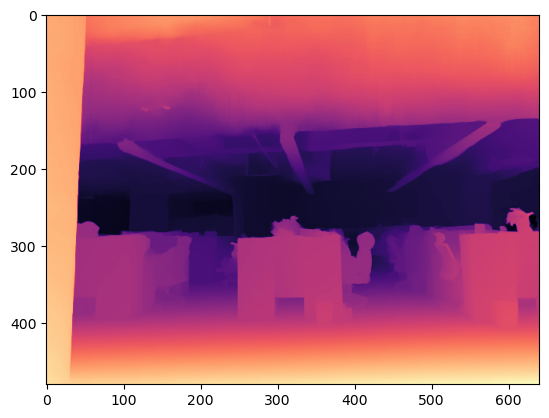

In [11]:
plt.figure()
plt.imshow(cres_numpy_output, cmap='magma')
plt.show()

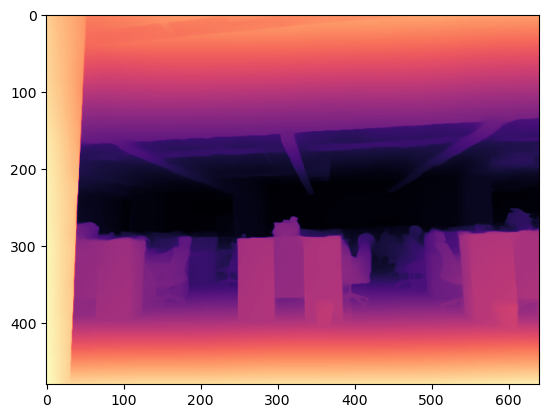

In [12]:
plt.figure()
plt.imshow(mono_numpy_output, cmap='magma')
plt.show()

In [13]:
cres_stereo_tensor = torch.from_numpy(cres_numpy_output).unsqueeze(0).unsqueeze(1)
mono_stereo_tensor = torch.from_numpy(mono_numpy_output).unsqueeze(0).unsqueeze(1)

In [34]:
refine_net= train_one_epoch(cres_stereo_tensor.to('cuda'), mono_stereo_tensor.to('cuda'), n_iters=500)

output shape is torch.Size([1, 1, 480, 640])
Epoch 0, Total Loss: 9.0332, Pixel Loss: 8.8888, Edge Loss: 0.2062
output shape is torch.Size([1, 1, 480, 640])
Epoch 1, Total Loss: 9.0166, Pixel Loss: 8.8872, Edge Loss: 0.1849
output shape is torch.Size([1, 1, 480, 640])
Epoch 2, Total Loss: 8.9956, Pixel Loss: 8.8856, Edge Loss: 0.1572
output shape is torch.Size([1, 1, 480, 640])
Epoch 3, Total Loss: 8.9894, Pixel Loss: 8.8834, Edge Loss: 0.1515
output shape is torch.Size([1, 1, 480, 640])
Epoch 4, Total Loss: 8.9863, Pixel Loss: 8.8788, Edge Loss: 0.1536
output shape is torch.Size([1, 1, 480, 640])
Epoch 5, Total Loss: 8.9753, Pixel Loss: 8.8748, Edge Loss: 0.1436
output shape is torch.Size([1, 1, 480, 640])
Epoch 6, Total Loss: 8.9707, Pixel Loss: 8.8710, Edge Loss: 0.1424
output shape is torch.Size([1, 1, 480, 640])
Epoch 7, Total Loss: 8.9671, Pixel Loss: 8.8661, Edge Loss: 0.1443
output shape is torch.Size([1, 1, 480, 640])
Epoch 8, Total Loss: 8.9593, Pixel Loss: 8.8590, Edge Loss:

In [ ]:
refine_net_reset = train_one_epoch_resnet(cres_stereo_tensor.to('cuda'), mono_stereo_tensor.to('cuda'), n_iters=500)

In [ ]:
refine_net_mbv3 = train_one_epoch_mbv3(cres_stereo_tensor.to('cuda'), mono_stereo_tensor.to('cuda'), n_iters=500)

In [35]:
refine_net.eval()

with torch.no_grad():
    # norm_stereo, v_min, v_max = tensor_norm(cres_stereo_tensor)
    # norm_mono, _, _ = tensor_norm(mono_stereo_tensor)
    norm_stereo = cres_stereo_tensor
    norm_mono = mono_stereo_tensor

    fusion_disp = refine_net(norm_stereo.to('cuda'), norm_mono.to('cuda'))
    # fusion_disp_backup = fusion_disp*(v_max-v_min)+v_min

In [36]:
fusion = fusion_disp.cpu().numpy()
# fusion_backup = fusion_disp_backup.cpu().numpy()

In [37]:
fusion = fusion[0,0,...]
print(fusion)

[[ 7.7173715  8.8742695 11.642316  ... 10.373497   7.25896    6.9728403]
 [ 9.259249   8.9924555 12.066889  ... 11.042152   8.529521   8.5293   ]
 [11.242772  11.538228  12.533223  ... 11.74105   10.550647  10.275288 ]
 ...
 [13.04739   13.680065  14.325819  ... 15.591226  14.728168  14.227705 ]
 [10.219582  10.672497  13.980699  ... 15.38571   12.369868  12.4865885]
 [ 9.014719  11.41853   14.147731  ... 13.500341  10.304068   8.064547 ]]


In [38]:
print(mono_numpy_output)

[[4.899589  4.877498  4.866714  ... 4.3076706 4.3492527 3.600375 ]
 [4.919932  4.8577075 4.8232794 ... 4.339977  4.254379  4.1151423]
 [4.900367  4.859409  4.8749313 ... 4.3423605 4.331066  4.2994246]
 ...
 [5.3741436 5.3813066 5.380779  ... 5.1638484 5.149842  5.168496 ]
 [5.3965325 5.3815565 5.379775  ... 5.195264  5.196157  5.1949015]
 [5.3248515 5.3834567 5.331273  ... 5.211009  5.2226243 5.2281513]]


In [29]:
# fusion_backup = fusion_backup[0,0,...]
# print(fusion_backup)

[[ 8.033481   9.703671  11.184143  ... 10.998613   9.539995   7.8271565]
 [ 9.5815525  9.842273  11.859487  ... 11.45709   10.031179   8.955717 ]
 [11.750618  11.947166  12.691617  ... 12.201325  11.651431  11.546079 ]
 ...
 [13.231781  13.893424  14.13245   ... 15.375398  14.649236  14.323336 ]
 [10.347188  12.26498   13.883181  ... 14.236204  12.88722   11.083495 ]
 [ 7.8832455 11.233721  12.901068  ... 14.680025  12.165562  10.041147 ]]


In [39]:
print(cres_numpy_output)

[[14.192608 14.202011 14.199517 ... 13.018124 13.018322 13.018267]
 [14.200415 14.197662 14.19595  ... 13.017286 13.010814 13.014877]
 [14.197171 14.193902 14.195598 ... 13.014473 13.007282 13.003704]
 ...
 [15.953414 15.967855 15.975756 ... 16.743542 16.727856 16.710512]
 [15.967464 15.97843  15.983091 ... 16.85468  16.842308 16.823545]
 [15.968182 15.981563 15.986776 ... 16.949951 16.93787  16.933857]]


In [92]:
refine_net_reset.eval()
refine_net_mbv3.eval()
orig_h, orig_w = 480, 640
with torch.no_grad():
    resnet_fusion_output = refine_net_reset(cres_stereo_tensor.to('cuda'), mono_stereo_tensor.to('cuda'))
    resnet_fusion_output = F.interpolate(resnet_fusion_output, (orig_h, orig_w), mode='bilinear', align_corners=True)
    mbv3_fusion_output = refine_net_mbv3(cres_stereo_tensor.to('cuda'), mono_stereo_tensor.to('cuda'))
    mbv3_fusion_output = F.interpolate(mbv3_fusion_output, (orig_h, orig_w), mode='bilinear', align_corners=True)

In [93]:
resent_fusion_numpy = resnet_fusion_output.cpu().squeeze(1).squeeze(0).numpy()
mbv3_fusion_numpy = mbv3_fusion_output.cpu().squeeze(1).squeeze(0).numpy()

In [ ]:
resent_fusion_numpy.shape

In [ ]:
mbv3_fusion_numpy

In [ ]:
resent_fusion_numpy

In [ ]:
plt.figure()
plt.imshow(resent_fusion_numpy, cmap='magma')
plt.show()

In [ ]:
plt.figure()
plt.imshow(mbv3_fusion_numpy, cmap='magma')
plt.show()